# Telco Custumer Churn

Neste projeto irei construir um modelo de machine learnig para prever a possibilidade de um cliente cancelar o contrato com uma operadora de telecomunicações. Trata-se de um problema de aprendizado supervisionado (utilizando um conjunto de dados rotulado) de classificação, em que o alvo (target) é 1 se o cliente cancelou o serviço e 0 caso contrário.

Pipiline de resolução usado no projeto(baseado no CRISPIM-DM)
1. Definir o problema de negócio.

2. Coletar os dados e obter uma visão geral deles.

3. Dividir os dados em conjuntos de treino e teste.

4. Explorar os dados (Análise Exploratória de Dados – EDA).

5. Engenharia de atributos, limpeza e pré-processamento dos dados.

6. Treinamento dos modelos, comparação, seleção de atributos e ajuste de hiperparâmetros.

7. Teste final do modelo em produção e avaliação.

8. Conclusão e interpretação dos resultados do modelo.

9. Implantação (deploy).


Neste notebook, irei realizar a modelagem de machine learning, cobrindo as etapas 5 a 8 do pipeline apresentado acima. O principal objetivo aqui é construir um modelo que possa prever com precisão a probabilidade de um cliente cancelar (churn). Após construir esse modelo, a empresa de telecomunicações podera prever a probabilidade de um cliente sair, e direcionar suas estratégias para retenção e fidelização do cliente. Adquirir novos clientes é mais caro do que manter os existentes. Além disso, abordarei essas etapas em detalhes a seguir, explicando o motivo de cada decisão tomada.


In [1]:
# Visualização e manipulação do dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


## Carregando os dados 

In [2]:
data_patch = '../data/WA_Fn-UseC_-Telco-Customer-Churn.xls'

df = pd.read_csv(data_patch)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


## Limpeza

Para otimizar a performance e a interpretabilidade do modelo, realizarei a exclusão de variáveis que não contribuem significativamente para o poder preditivo:

* customerID: Removido por tratar-se de um identificador único de natureza administrativa, sem valor estatístico para o aprendizado do modelo.

* gender: Excluído após a EDA demonstrar que a distribuição de Churn é praticamente idêntica entre os gêneros, não apresentando ganho de informação (Information Gain) relevante.

* TotalCharges: Conforme observado na análise de correlação, esta variável apresenta altíssima colinearidade com o tenure (r=0.83). Em modelos lineares, como a Regressão Logística, a presença de variáveis redundantes pode inflar os erros padrão e dificultar a identificação da real importância de cada atributo (problema de multicolinearidade)."

Além disso, irei padronizar o nome da coluna tenure. 

In [5]:
df = df.drop(columns=['customerID', 'gender','TotalCharges'])

In [6]:
#padronizando nomes das colunas
df = df.rename(columns={ 'tenure' : 'Tenure' })

## 3. Separando os dados entre treino e test (Split)

* Irei separar os dados entre treino e teste para evitar o DataLekage, e garantir a capacidade de genereralização do modelo. 

In [7]:
X = df.drop(columns = ['Churn'])
y = df['Churn'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state =42)

print(f"Treino: {X_train.shape[0]} amostras | Teste: {X_test.shape[0]} amostras")

Treino: 5634 amostras | Teste: 1409 amostras


In [8]:
print(f"Treno: {y_train.value_counts(normalize = True)}")
print(f"Teste: {y_test.value_counts(normalize = True)}")

Treno: Churn
No     0.734647
Yes    0.265353
Name: proportion, dtype: float64
Teste: Churn
No     0.734564
Yes    0.265436
Name: proportion, dtype: float64


* as proporções entre treino e teste foram mantidas.

## 5. Engenharia de atributos, limpeza e pré-processamento dos dados.



Nesta próxima etapa, transformarei os dados brutos em sinais claros e acionáveis para os algoritmos. O foco não será apenas a "limpeza", mas sim garantir que o modelo final esteja protegido contra viés, vazamento de dados (*data leakage*) e instabilidade numérica.

Abaixo, detalho as decisões estratégicas que implementarei na preparação do dataset:


#### 1. Engenharia de Atributos (Feature Engineering)

Embora eu remova a variável TotalCharges original para evitar multicolinearidade com tenure, criarei novas métricas para capturar padrões:

* **Serviços De Segurança:** Criarei uma contagem de quantos serviços extras o cliente possui ('TechSupport', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection').Vimos que os clientes que utilizam esses serviços tem baixa aderencia de churn. Usaremos essa informação para identificar os clientes que não utilizam esse serviço, e que consequentemente tem mais propensão ao churn.
  
* **Segmentação de Faturamento:** Realizarei a binatização de faturas muito acima da média para identificar explicitamente o "choque de preço" notado na EDA.

#### 2. Codificação de Variáveis Categóricas (Encoding)

Como os modelos matemáticos não interpretam texto, traduzirei as categorias em números, tomando cuidado para não criar hierarquias falsas:

* **One-Hot Encoding (OHE):** Aplicarei em variáveis como PaymentMethod. Para evitar a "Armadilha da Variável Dummy", utilizarei o parâmetro drop='first, removendo colunas redundantes.
* **Ordinal/Binary Encoding:** Para variáveis "Yes/No", utilizarei uma codificação binária simples (0 e 1), mantendo o dataset leve.

#### 3. Escalonamento de Atributos (Feature Scaling)

Para garantir o bom desempenho de algoritmos sensíveis à escala (baseados em distância ou gradiente), padronizarei os dados numéricos.

* **StandardScaler:** Aplicarei a padronização () nas variáveis tenure e MonthlyCharges.
* **Prevenção de Data Leakage:** Garantirei que o *fit* do escalonador seja feito **exclusivamente no conjunto de treino**. O conjunto de teste será apenas transformado, simulando dados inéditos em produção.

#### 4. Arquitetura de Pipeline

Para tornar todo esse processo reprodutível e robusto, utilizarei o ColumnTransformer dentro de um Pipeline do Scikit-Learn. Isso encapsulará o pré-processamento e o modelo em um único objeto treinável.



In [9]:
df_train = pd.concat([X_train, y_train], axis = 1)

df_train.head(3)

,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
3738,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,No
3151,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,No
4860,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,No


In [10]:
df_test = pd.concat([X_test, y_test], axis = 1)

* Irei criar a contagem de servições de segurança o cliente possui

In [11]:
retention_services = ['TechSupport', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']

df_train['Security_Svc_Count'] = (df_train[retention_services] == 'Yes').sum(axis=1)

df_train.drop(columns=retention_services, inplace=True)

In [12]:
#implementar as mudanças no teste 
retention_services = ['TechSupport', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']

df_test['Security_Svc_Count'] = (df_test[retention_services] == 'Yes').sum(axis=1)

df_test.drop(columns=retention_services, inplace=True)

* Irei criar a fragmentação do faturamento.

In [13]:
limiar_treino = df_train['MonthlyCharges'].quantile(0.80)

def aplicar_choque_faturamento(df, corte):
    df['Is_Price_Shock'] = (df['MonthlyCharges'] > corte).astype(int)
    return df

df_train = aplicar_choque_faturamento(df_train, limiar_treino)

#utilizei o valor calculado no teste, no treino para evitar o vazamento de dados 
df_test = aplicar_choque_faturamento(df_test, limiar_treino) 


In [14]:
binary_features = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling','Churn',
    'MultipleLines', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen']

mapping = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}

for col in binary_features:
    if col in df_train.columns:
        df_train[col] = df_train[col].map(mapping).fillna(0).infer_objects(copy=False).astype(int)
        
    if col in df_test.columns:
        df_test[col] = df_test[col].map(mapping).fillna(0).infer_objects(copy=False).astype(int)

/tmp/ipykernel_19171/44912933.py:8: Pandas4Warning: The copy keyword is deprecated and will be removed in a future version. Copy-on-Write is active in pandas since 3.0 which utilizes a lazy copy mechanism that defers copies until necessary. Use .copy() to make an eager copy if necessary.
  df_train[col] = df_train[col].map(mapping).fillna(0).infer_objects(copy=False).astype(int)
/tmp/ipykernel_19171/44912933.py:11: Pandas4Warning: The copy keyword is deprecated and will be removed in a future version. Copy-on-Write is active in pandas since 3.0 which utilizes a lazy copy mechanism that defers copies until necessary. Use .copy() to make an eager copy if necessary.
  df_test[col] = df_test[col].map(mapping).fillna(0).infer_objects(copy=False).astype(int)
/tmp/ipykernel_19171/44912933.py:8: Pandas4Warning: The copy keyword is deprecated and will be removed in a future version. Copy-on-Write is active in pandas since 3.0 which utilizes a lazy copy mechanism that defers copies until necessa

Para a codificação das variáveis categóricas, optei pelo uso do objeto OneHotEncoder do Scikit-Learn em vez do método pd.get_dummies. Esta escolha fundamenta-se em três pilares estratégicos:

* Prevenção de Data Leakage. Diferente do get_dummies, que atua de forma global, o OneHotEncoder permite isolar o aprendizado do vocabulário estritamente no conjunto de treino. Esse conhecimento é então aplicado ao conjunto de teste, garantindo uma avaliação imparcial e realista do modelo.

* O uso do encoder garante que a estrutura de colunas (o shape do dataset) seja idêntica em ambos os conjuntos. Com o parâmetro handle_unknown='ignore', o pipeline torna-se resiliente a novas categorias presentes apenas nos dados de teste ou produção, evitando falhas de execução no modelo.

* Ao reconstruir os DataFrames pós-transformação respeitando os índices originais, asseguro a perfeita integridade dos dados durante a concatenação, eliminando o risco de desalinhamento de informações sensíveis dos clientes

In [15]:
one_hot_features = ['Contract', 'PaymentMethod', 'InternetService']

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

encoded_train = encoder.fit_transform(df_train[one_hot_features])

encoded_test = encoder.transform(df_test[one_hot_features])

encoded_cols = encoder.get_feature_names_out(one_hot_features)

df_train_encoded = pd.DataFrame(encoded_train, columns=encoded_cols, index=df_train.index)
df_test_encoded = pd.DataFrame(encoded_test, columns=encoded_cols, index=df_test.index)

df_train = pd.concat([df_train.drop(one_hot_features, axis=1), df_train_encoded], axis=1)
df_test = pd.concat([df_test.drop(one_hot_features, axis=1), df_test_encoded], axis=1)


* Irei apliacr o StandardScaler para padronizar as variáveis numéricas. Como os algoritmos de Machine Learning são sensíveis à magnitude dos números, a padronização garante que todas as variáveis contribuam igualmente para o modelo, evitando que atributos com escalas maiores (como cobranças mensais) dominem o aprendizado em detrimento de variáveis binárias ou de menor escala.

In [16]:
numerical_features = ['Tenure', 'MonthlyCharges', 'Security_Svc_Count']

scaler = StandardScaler()

df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])

df_test[numerical_features] = scaler.transform(df_test[numerical_features])

In [17]:
df_train.info()

<class 'pandas.DataFrame'>
Index: 5634 entries, 3738 to 5639
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          5634 non-null   int64  
 1   Partner                                5634 non-null   int64  
 2   Dependents                             5634 non-null   int64  
 3   Tenure                                 5634 non-null   float64
 4   PhoneService                           5634 non-null   int64  
 5   MultipleLines                          5634 non-null   int64  
 6   StreamingTV                            5634 non-null   int64  
 7   StreamingMovies                        5634 non-null   int64  
 8   PaperlessBilling                       5634 non-null   int64  
 9   MonthlyCharges                         5634 non-null   float64
 10  Churn                                  5634 non-null   int64  
 11  Security_Svc_Coun

### 6. Treinamento dos modelos, comparação, seleção de atributos e ajuste de hiperparâmetros.


## TO DO 
* Estudar um pouco mais a parte teorica dos modelos OK
* Instanciar os modelos (Regressão Logística, Random Forest e XGBoost). OK
* Treinar com Cross-Validation para ver quem performa melhor de forma estável. OK
* Tunar os hiperparâmetros do campeão.
* Escrever o storyle descrevendo o processo.

In [18]:
#Instanciando modelos
models = {"Logistic Regression": LogisticRegression(class_weight = 'balanced', random_state=42), 
                "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
                "XGBoost": XGBClassifier(scale_pos_weight=3, random_state=42)
                }
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
results = []

# Definimos as métricas
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, model in models.items():
    print(f"Treinando {name}...")
    
   
    X = df_train.drop(columns=['Churn']).values 
    y = df_train['Churn'].values
    
    cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring)
    
    results.append({
        "Model": name,
        "Recall": cv_results['test_recall'].mean(),
        "Precision": cv_results['test_precision'].mean(),
        "F1-Score": cv_results['test_f1'].mean(),
        "ROC-AUC": cv_results['test_roc_auc'].mean(),
        "Accuracy": cv_results['test_accuracy'].mean()
    })

# Visualização
df_results = pd.DataFrame(results).sort_values(by="Recall", ascending=False)
display(df_results)

Treinando Logistic Regression...
Treinando Random Forest...
Treinando XGBoost...


,Model,Recall,Precision,F1-Score,ROC-AUC,Accuracy
0,Logistic Regression,0.796656,0.517183,0.627054,0.844771,0.748671
2,XGBoost,0.682943,0.533137,0.598706,0.816377,0.757189
1,Random Forest,0.460201,0.598583,0.520073,0.810180,0.774763


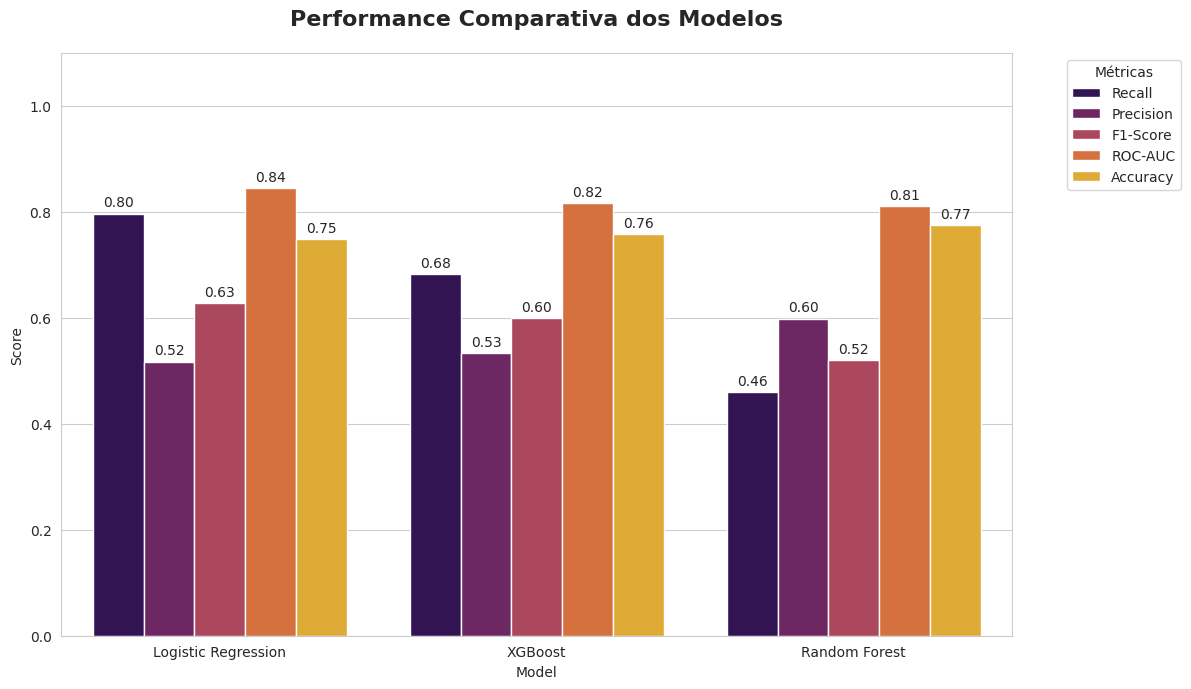

In [20]:
df_plot = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))


ax = sns.barplot(data=df_plot, x='Model', y='Score', hue='Metric', palette='inferno')

plt.title('Performance Comparativa dos Modelos', fontsize=16, fontweight='bold', pad=20)
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.1) 

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

In [22]:

X = df_train.drop(columns=['Churn']).values 
y = df_train['Churn'].values
    
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],              
    'solver': ['liblinear']              
}

log_reg_base = LogisticRegression(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=log_reg_base,
    param_grid=param_grid,
    scoring='recall',      
    cv=skf,                
    n_jobs=-1,             
    verbose=1             
)

print("Iniciando a busca pelos melhores hiperparâmetros...")
grid_search.fit(X, y) 

print("\n--- Resultados do Tuning ---")
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Melhor Recall Médio (Cross-Validation): {grid_search.best_score_:.4f}")

best_log_reg = grid_search.best_estimator_

Iniciando a busca pelos melhores hiperparâmetros...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/rebeca/Documentos/PROJETOS/Telco-Customer-Churn-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/rebeca/Documentos/PROJETOS/Telco-Customer-Churn-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/rebeca/Documentos/PROJETOS/Telco-Customer-Churn-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its defau


--- Resultados do Tuning ---
Melhores Parâmetros: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor Recall Médio (Cross-Validation): 0.8060


/home/rebeca/Documentos/PROJETOS/Telco-Customer-Churn-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/rebeca/Documentos/PROJETOS/Telco-Customer-Churn-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
